<a href="https://colab.research.google.com/github/Epistimonas/imagenes/blob/master/New_York_City_Taxi_Fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-04-25 00:03:33          57332  
roche-data-science-coalition/uncover                           UNCOVER COVID-19 Challenge                          123MB  2020-04-08 22:04:30           5387  
praveengovi/coronahack-chest-xraydataset                       CoronaHack -Chest X-Ray-Dataset                       1GB  2020-03-20 01:26:40           1433  
katerpillar/meteonet                                           MeteoNet North-West France                           11GB  2020-04-16 08:35:45            113  
andrewmvd/co

In [3]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 419kB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 63.5MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 107MB/s]
100% 1.55G/1.56G [00:26<00:00, 47.2MB/s]
100% 1.56G/1.56G [00:26<00:00, 62.2MB/s]


In [0]:
import numpy as np 
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import os

In [5]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
ls

In [6]:
train_df =  pd.read_csv('train.csv', nrows = 12_000_000) #1M to test models
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [7]:
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    79
dropoff_latitude     79
passenger_count       0
dtype: int64


In [0]:
train_df = train_df.dropna(how = 'any', axis = 'rows')

In [9]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.199992e+07,1.199992e+07,1.199992e+07,1.199992e+07,1.199992e+07,1.199992e+07
mean,1.133837e+01,-7.251054e+01,3.991976e+01,-7.251034e+01,3.992025e+01,1.684960e+00
std,9.797542e+00,1.291233e+01,9.262672e+00,1.277134e+01,9.347702e+00,1.325026e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075264e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396709e+01,4.076712e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.400392e+03,2.080000e+02


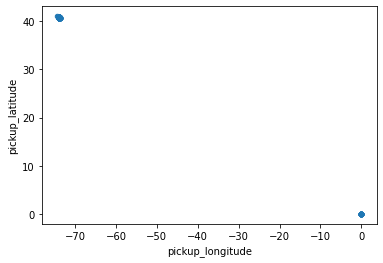

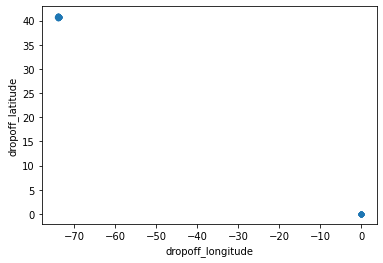

In [10]:
#Plot variables using only 1000 rows for efficiency
train_df.iloc[:1000].plot.scatter('pickup_longitude', 'pickup_latitude')
train_df.iloc[:1000].plot.scatter('dropoff_longitude', 'dropoff_latitude')

#Get distribution of values
train_df.describe()

In [11]:
#Clean dataset
def clean_df(df):
    return df[(df.fare_amount > 0) & 
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45) &
            (df.passenger_count > 0) & (df.passenger_count < 10)]

train_df = clean_df(train_df)
print(len(train_df))

11708572


In [12]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 2 * R_earth * np.arcsin(np.sqrt(a))

def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['jfk_dist'] = pd.concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    dataset['ewr_dist'] = pd.concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    dataset['lga_dist'] = pd.concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return dataset
    
def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

train_df = add_datetime_info(train_df)
train_df = add_airport_dist(train_df)
train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])

train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,9.647141,27.523051,6.660494,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,21.525635,13.029641,8.996046,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,21.735040,16.282199,9.442812,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,20.401167,15.949684,10.241872,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,21.397709,18.867107,7.113348,1.999157


In [13]:
train_df.drop(columns=['key', 'pickup_datetime'], inplace=True)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,jfk_dist,ewr_dist,lga_dist,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,0,2009,9.647141,27.523051,6.660494,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,1,2010,21.525635,13.029641,8.996046,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,3,2011,21.735040,16.282199,9.442812,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,5,2012,20.401167,15.949684,10.241872,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,1,2010,21.397709,18.867107,7.113348,1.999157


In [0]:
y = train_df['fare_amount']
train = train_df.drop(columns=['fare_amount'])

x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=0,test_size=0.01)

In [15]:
#Cross-validation
params = {
    # Parameters that we are going to tune.
    'max_depth': 8, #Result of tuning with CV
    'eta':.03, #Result of tuning with CV
    'subsample': 1, #Result of tuning with CV
    'colsample_bytree': 0.8, #Result of tuning with CV
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1
}

#Block of code used for hypertuning parameters. Adapt to each round of parameter tuning.
#Turn off CV in submission
CV=False
if CV:
    dtrain = xgb.DMatrix(train,label=y)
    gridsearch_params = [
        (eta)
        for eta in np.arange(.04, 0.12, .02)
    ]

    # Define initial best params and RMSE
    min_rmse = float("Inf")
    best_params = None
    for (eta) in gridsearch_params:
        print("CV with eta={} ".format(
                                 eta))

        # Update our parameters
        params['eta'] = eta

        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=1000,
            nfold=3,
            metrics={'rmse'},
            early_stopping_rounds=10
        )

        # Update best RMSE
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = (eta)

    print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
else:
    #Print final params to use for the model
    params['silent'] = 0 #Turn on output
    print(params)

{'max_depth': 8, 'eta': 0.03, 'subsample': 1, 'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': 0}


In [16]:
def XGBmodel(x_train,x_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)     
    model=xgb.train(params=params,                     
                    dtrain=matrix_train,num_boost_round=5000,      
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])     
    return model                  
   
model = XGBmodel(x_train,x_test,y_train,y_test,params)

[19:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:22:18] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:14.1508
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.7657
[2]	test-rmse:13.4069
[3]	test-rmse:13.0445
[4]	test-rmse:12.6944
[5]	test-rmse:12.3696
[6]	test-rmse:12.0413
[7]	test-rmse:11.7247
[8]	test-rmse:11.4189
[9]	test-rmse:11.1361
[10]	test-rmse:10.8494
[11]	test-rmse:10.5723
[12]	test-rmse:10.3052
[13]	test-rmse:10.05
[14]	test-rmse:9.80241
[15]	test-rmse:9.56213
[16]	test-rmse:9.3299
[17]	test-rmse:9.10678
[18]	test-rmse:8.89044
[19]	test-rmse:8.68297
[20]	test-rmse:8.48272
[21]	test-rmse:8.29975
[22]	test-rmse:8.12491
[23]	test-rmse:7.95218
[24]	test-rmse:7.77831
[25]	test-rmse:7.61107
[26]	test-rmse:7.

In [0]:
#Read and preprocess test set
test_df =  pd.read_csv('test.csv')
test_df = add_datetime_info(test_df)
test_df = add_airport_dist(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_key = test_df['key']
x_pred = test_df.drop(columns=['key', 'pickup_datetime'])

#Predict from test set
prediction = model.predict(xgb.DMatrix(x_pred), ntree_limit = model.best_ntree_limit)

In [19]:
#Create submission file
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.round(2)
})

submission.to_csv('taxi_fare_submission.csv',index=False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.080000
1,2015-01-27 13:08:24.0000003,10.640000
2,2011-10-08 11:53:44.0000002,4.530000
3,2012-12-01 21:12:12.0000002,9.390000
4,2012-12-01 21:12:12.0000003,16.389999
